<a href="https://colab.research.google.com/github/XineohpM/Computational_Physics_PHYS_411/blob/main/PHYS_411_HW2_Xiaoyue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Exercise 5.7
Consider the integral:
$$I=\int^{1}_{0} \text{sin}^{2} \left( \sqrt{100x} \right)  dx$$

**(a)** Write a program that uses the adaptive trapezoidal rule method of Section 5.3 and Eq. (5.34) to calculate the value of this integral to an approximate accuracy of $\varepsilon=10^{-6}$ (i.e. correct to six digits after the decimal point). Start with one single integration slice and work up from there to two, four, eight, and so forth. Have your program print out the number of slices, its estimate of the integral, and its estimate of the error on the integral, for each value of the number of slices $N$,
until the target accuracy is reached. (Hint: You should find the result is around $I=0.45$.)

In [6]:
import numpy as np


def func(x):
    return np.sin(np.sqrt(100 * x)) ** 2

def int_trapezoidal_adaptive(func, a, b, I_old, N):
    dx = (b - a) / (2 * N)

    I_new = 0.
    for i in range(1, 2 * N, 2):
      I_new += func(a + i * dx)

    I_new *= dx
    I_new += 0.5 * I_old

    return I_new

def adaptive_trapezoidal(func, a, b, epsilon):
    I = []
    I.append(0.5 * (func(a) + func(b)) * (b - a))
    error = 999.
    N = 1
    step = 0

    while error > epsilon:
        I.append(int_trapezoidal_adaptive(func, a, b, I[step], N))
        error = abs((np.asarray(I[step + 1]) - np.asarray(I[step])) / 3)
        N *= 2
        step += 1

    print("All integrated values are:", I)
    print("The estimated integral is:", I[-1])
    print("The number of slices used is:", 2 ** step)
    print("The estimated error is:", error, ", which is less than 1e-6.")

adaptive_trapezoidal(func, 0.0, 1.0, 1e-6)

All integrated values are: [0.147979484546652, 0.3252319078064746, 0.5122828507233315, 0.4029974484782483, 0.43010336929474696, 0.4484146657874699, 0.4539129312153758, 0.45534850437280205, 0.455711266453241, 0.45580219965166413, 0.45582494813241997, 0.45583063620164654, 0.455832058278271]
The estimated integral is: 0.455832058278271
The number of slices used is: 4096
The estimated error is: 4.740255414859007e-07 , which is less than 1e-6.


**(b)** Now modify your program to evaluate the same integral using the Romberg integration technique described in this section. Have your program print out a
triangular table of values, as on page 161, of all the Romberg estimates of the integral. Calculate the error on your estimates using Eq. (5.49) and again continue
the calculation until you reach an accuracy of $\varepsilon = 10^{-6}$. You should find that
the Romberg method reaches the required accuracy considerably faster than the
trapezoidal rule alone.

In [24]:
import numpy as np


def func(x):
    return np.sin(np.sqrt(100 * x)) ** 2

def romberg(func, a, b, tol = 1e-6):
    R = []
    h = b - a
    R.append([(h/2.0) * (func(a) + func(b))])

    i = 0
    error = 999.
    max_iteration = 10

    while error > tol and i < max_iteration:
        i += 1
        h /= 2.
        sum = np.sum(func(a + np.arange(1, 2 ** i, 2) * h))

        row_i = [0.5 * R[i - 1][0] + sum * h]
        for m in range(1, i + 1):
            r_im = row_i[m - 1] + (row_i[m - 1] - R[i - 1][m - 1]) / (4 ** m - 1)
            row_i.append(r_im)

        R.append(row_i)
        error = abs(R[i][i] - R[i-1][i-1])

    return R, error

def print_romberg(R):
    for row in R:
        print(' '.join(['{:.8f}'.format(elem) for elem in row]))

R, error = romberg(func, 0., 1., 1e-6)
print_romberg(R)
print("Estimated error:", error)

0.14797948
0.32523191 0.38431605
0.51228285 0.57463317 0.58732097
0.40299745 0.36656898 0.35269804 0.34897386
0.43010337 0.43913868 0.44397666 0.44542552 0.44580376
0.44841467 0.45451843 0.45554375 0.45572735 0.45576775 0.45577749
0.45391293 0.45574569 0.45582750 0.45583201 0.45583242 0.45583248 0.45583249
0.45534850 0.45582703 0.45583245 0.45583253 0.45583253 0.45583253 0.45583253 0.45583253
Estimated error: 3.784363489245379e-08


## 2. Exercise 5.9
Debye's theory of solids gives the heat capacity of a solid at temperature $T$ to be:
$$C_{V}=9V\rho k_{B}\left( \frac{T}{\theta_{D} } \right)^{3}  \int^{\theta_{D} /T}_{0} \frac{x^{4}e^{x}}{(e^{x}-1)^{2}} \text{d} x$$
where $V$ is the volume of the solid, pis the number density of atoms, $k_{B}$ is Boltzmann's constant, and $\theta_{D}$ is the so-called Debye temperature, a property of solids that depends on their density and speed of sound.

**(a)** Write a Python function **cv(T)** that calculates $C_{v}$ for a given value of the temperature, for a sample consisting of 1000 cubic centimeters of solid aluminum, which has a number density of $\rho=6.022 \times 10^{28} m^{-3}$ and a Debye temperature of $\theta_{D}= 428 K$. Use Gaussian quadrature to evaluate the integral, with $N = 50$ sample points.

In [1]:
import numpy as np
import math


def gaussxw(N):
    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3, 4 * N - 1, N) / (4 * N + 2)
    x = np.cos(np.pi * a + 1/(8 * N * N * np.tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta > epsilon:
        p0 = np.ones(N, float)
        p1 = np.copy(x)
        for k in range(1, N):
            p0, p1 = p1, ((2 * k + 1) * x * p1 - k * p0) / (k + 1)
        dp = (N + 1) * (p0 - x * p1) / (1 - x * x)
        dx = p1 / dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2 * (N + 1) * (N + 1) / (N * N * (1 - x * x) * dp * dp)

    return x, w

def gaussxwab(N, a, b):
    x, w = gaussxw(N)
    return 0.5 * (b - a) * x + 0.5 * (b + a), 0.5 * (b - a) * w

def to_be_integrated(x):
  return (x ** 4) * np.exp(x) / ((np.exp(x) - 1) ** 2)

def gaussian_quadrature(func, T):
  N = 50
  theta_D = 428
  x, w = gaussxwab(N, 0, theta_D / T)
  y = func(x)

  integral = 0
  for i in range(0, N):
    integral += w[i] * y[i]

  return integral

def cv(T):
  return 9 * (1e-3) * (6.022e28) * (1.38e-23) * ((T / 428) ** 3) * gaussian_quadrature(to_be_integrated, T)

## Print the heat capacity of Al at T = 300 K.
print(cv(300))

2256.7359849063123


**(b)** Use your function to make a graph of the heat capacity as a function of temperature from $T = 5 K$ to $T = 500 K$.

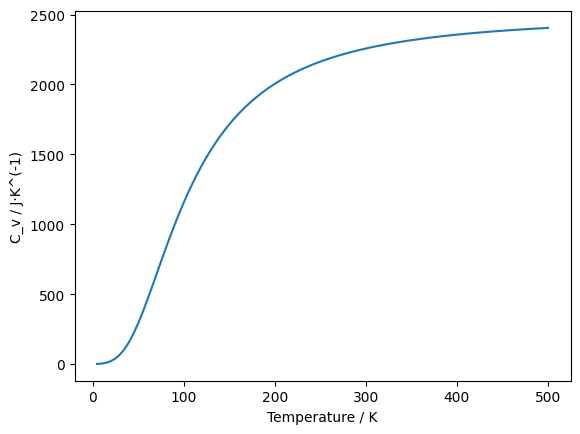

In [ ]:
import matplotlib.pyplot as plt


T = np.linspace(5, 500, 100)
C = [cv(T_i) for T_i in T]
plt.plot(T, C)
plt.xlabel('Temperature / K')
plt.ylabel('C_v / J·K^(-1)')
plt.show()

## 3. Exercise 5.10
The simple harmonic oscillator crops up in many places. Its behavior can be studied readily using analytic methods and it has the important property that its period of oscillation is a constant, independent of its amplitude, making it useful, for instance, for keeping time in watches and clocks.

Frequently in physics, however, we also come across anharmonic oscillators, whose period varies with amplitude and whose behavior cannot usually be calculated analytically. A general classical oscillator can be thought of as a particle in a concave potential well. When disturbed, the particle will rock back and forth in the well.

The harmonic oscillator corresponds to a quadratic potential $V(x)\propto x^{2}$ . Any other form gives an anharmonic oscillator. (Thus there are many different kinds of anharmonic oscillator, depending on the exact form of the potential.) One way to calculate the motion of an oscillator is to write down the equation for the conservation of energy in the system. If the particle has mass m and position $x$, then the total energy is equal to the sum of the kinetic and potential energies thus:
$$E=\frac{1}{2} m\left( \frac{\text{d} x}{\text{d} t} \right)^{2}  +V(x)$$.
Since the energy must be constant over time, this equation is effectively a (nonlinear) differential equation linking $x$ and $t$. Let us assume that the potential $V(x)$ is symmetric about $x=0$ and let us set our anharmonic oscillator going with amplitude $a$. That is, at $t=0$ we release it from rest at position $x=a$ and it swings back towards the origin. Then at $t=0$ we have $\text{d}x/\text{d}t = 0$
and the equation above reads $E=V(a)$, which gives us the total energy of the particle in terms of the amplitude.

**(a)** When the particle reaches the origin for the first time, it has gone through one quarter of a period of the oscillator. By rearranging the equation above for $\text{d}x/\text{d}t$ and then integrating with respect to $t$ from $0$ to $\frac{1}{4}T$, show that the period $T$ is
given by
$$T=\sqrt{8m} \int^{a}_{0} \frac{\text{d} x}{\sqrt{V(a)-V(x)} } $$

Since at $t=0$, $\text{d}x/\text{d}t=0$, $x=a$, $E=V(a)$.

Then $V(a)-V(x)=\frac{1}{2} m\left( \frac{\text{d} x}{\text{d} t} \right)^{2}  $, $\text{d} x=\sqrt{2\frac{V(a)-V(x)}{m} } \text{d} t$.

Then $T=4\int^{\frac{1}{4} T}_{0} \text{d} t=4\int^{a}_{0} \sqrt{\frac{m}{2\left[ V(a)-V(x)\right]  } } \text{d} x=\sqrt{8m} \int^{a}_{0} \frac{\text{d} x}{\sqrt{V(a)-V(x)} } $.

**(b)** Suppose the potential is $V(x)=x^{4}$ and the mass of the particle is $m=1$. Write a Python function that calculates the period of the oscillator for given amplitude a using Gaussian quadrature with $N = 20$ points, then use your function to make a graph of the period for amplitudes ranging from $a = 0$ to $a = 2$.

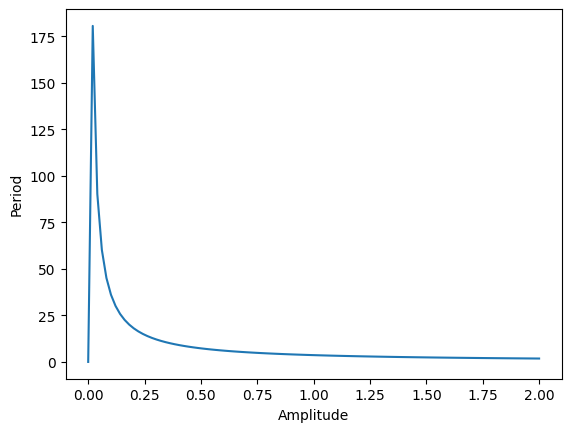

In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt


def gaussxw(N):
    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3, 4 * N - 1, N) / (4 * N + 2)
    x = np.cos(np.pi * a + 1/(8 * N * N * np.tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta > epsilon:
        p0 = np.ones(N, float)
        p1 = np.copy(x)
        for k in range(1, N):
            p0, p1 = p1, ((2 * k + 1) * x * p1 - k * p0) / (k + 1)
        dp = (N + 1) * (p0 - x * p1) / (1 - x * x)
        dx = p1 / dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2 * (N + 1) * (N + 1) / (N * N * (1 - x * x) * dp * dp)

    return x, w

def gaussxwab(N, a, b):
    x, w = gaussxw(N)
    return 0.5 * (b - a) * x + 0.5 * (b + a), 0.5 * (b - a) * w

def V(x):
  return x ** 4

def func(x, a):
  return 1 / np.sqrt(V(a) - V(x))


def period(m, a, func):
  if a == 0:
    return 0
  N = 20
  x, w = gaussxwab(N, 0, a)
  y = func(x, a)

  integral = 0
  for i in range(0, N):
    integral += w[i] * y[i]

  return np.sqrt(8 * m) * integral

m = 1
a = np.linspace(0, 2, 100)
T = [period(m, a_i, func) for a_i in a]
plt.plot(a, T)
plt.xlabel('Amplitude')
plt.ylabel('Period')
plt.show()

**(c)** You should find that the oscillator gets faster as the amplitude increases, even though the particle has further to travel for larger amplitude. And you should find that the period diverges as the amplitude goes to zero. How do you explain these results?

Since the total energy of the oscillator is $V(a)=a^{4}$, the larger the amplitude, the greater the total energy. Calculating the integral gives that period is inversely proportional toamplitude, i.e. $T\propto \frac{1}{a} $, thus the oscillator gets faster (shorter period) as the amplitude increases, and the period diverges as the amplitude goes to $0$.

## 4. Exercise 5.14
A uniform square sheet of metal is floating motionless in space. The sheet is $10 m$ on a side and of negligible thickness, and it has a mass of $10$ metric
tonnes.

**(a)** Consider the gravitational force due to the plate felt by a point mass of $1 kg$ a distance $z$ from the center of the square, in the direction perpendicular to the sheet, as shown above. Show that the component of the force along the $z$-axis is
$$F_{z}=G\sigma z\int \int^{L/2}_{-L/2} \frac{\text{d} x\text{d} y}{(x^{2}+y^{2}+z^{2})^{3/2}} $$
Where $G=6.674\times 10^{-11}\ m^{3}\ kg^{-1}\ s^{-2}$ is Newton's gravitational constant and $\sigma$ is the mass per unit area of the sheet.

According to Newton's law of universal gravitation, the graviational force between two point masses at distance $r$ with masses $m_{1}$ and $m_{2}$ is $F=G\frac{m_{1}m_{2}}{r^{2}} $.

Then the graviational force $F_{\sigma}$ between the point mass and an arbitrary differential area element $\text{d}x\text{d}y$ at $(x,y)$ is $F_{\sigma}=G\frac{m\sigma \text{d} x\text{d} y}{x^{2}+y^{2}+z^{2}} $, the component of $F_{\sigma}$ along the $z$-axis is $F_{\sigma ,z}=F_{\sigma }\frac{z}{\sqrt{x^{2}+y^{2}+z^{2}} } =G\frac{m\sigma \text{d} x\text{d} y}{x^{2}+y^{2}+z^{2}} \frac{z}{\sqrt{x^{2}+y^{2}+z^{2}} } $.

Integrate over $x$ and $y$ axis, $F_{z}=G\sigma z\int \int^{L/2}_{-L/2} \frac{\text{d} x\text{d} y}{(x^{2}+y^{2}+z^{2})^{3/2}} $.

**(b)** Write a program to calculate and plot the force as a function of z from $z = 0$ to $z = 10m$. For the double integral use (double) Gaussian quadrature, as in Eq. (5.82), with $100$ sample points along each axis.

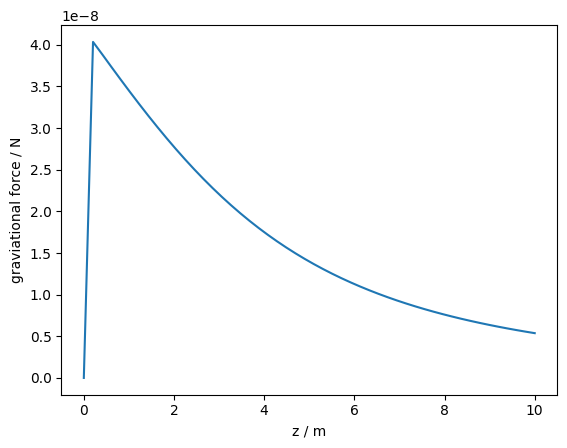

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


def gaussxw(N):
    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3, 4 * N - 1, N) / (4 * N + 2)
    x = np.cos(np.pi * a + 1/(8 * N * N * np.tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta > epsilon:
        p0 = np.ones(N, float)
        p1 = np.copy(x)
        for k in range(1, N):
            p0, p1 = p1, ((2 * k + 1) * x * p1 - k * p0) / (k + 1)
        dp = (N + 1) * (p0 - x * p1) / (1 - x * x)
        dx = p1 / dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2 * (N + 1) * (N + 1) / (N * N * (1 - x * x) * dp * dp)

    return x, w

def gaussxwab(N, a, b):
    x, w = gaussxw(N)
    return 0.5 * (b - a) * x + 0.5 * (b + a), 0.5 * (b - a) * w

def integral(x, y, z):
  return 1 / ((x ** 2 + y ** 2 + z ** 2) ** (3 / 2))

def double_integral(func, z):
  N = 100
  L = 10
  pts, w = gaussxwab(N, -(L / 2), L / 2)

  result = 0
  for i in range(0, N):
    for j in range(0, N):
      result += w[i] * w[j] * func(pts[i], pts[j], z)

  return result

G = 6.674e-11
sigma = 1e4 / (10 * 10)
z = np.linspace(0, 10, 50)
graviational_force = [G * sigma * z_i * double_integral(integral, z_i) for z_i in z]
plt.plot(z, graviational_force)
plt.xlabel("z / m")
plt.ylabel("graviational force / N")
plt.show()

**(c)** You should see a smooth curve, except at very small values of $z$, where the force should drop off suddenly to zero. This drop is not a real effect, but an artifact of the way we have done the calculation. Explain briefly where this artifact comes from and suggest a strategy to remove it, or at least to decrease its size.

Gaussian quadrature assumes the function to be integrated is relatively smooth over the interval, and with a steep gradient near the singularity, this assumption breaks down, leading to significant errors. When $z$ is very small, the integrand becomes very steep around the origin (where $x$ and $y$ are also very small).

This issue can be improved by dividing the integration domain into regions, with one region containing the singularity. Then, use different integration strategies for each region, possibly with a more refined approach near the singularity.

## 5. Exercise 5.17
A commonly occurring function in physics calculations is
the gamma function $\Gamma_{a}$, which is defined by the integral
$$\Gamma (a)=\int^{\infty }_{0} x^{a-1}e^{-x}\text{d} x$$
There is no closed-form expression for the gamma function, but one can calculate its value for given $n$ by performing the integral above numerically. You have to be careful how you do it, however, if you wish to get an accurate answer.

**(a)** Write a program to make a graph of the value of the integrand $x^{a-1}e^{-x}$ as a function of $x$ from $x = 0$ to $x = 5$, with three separate curves for $a = 2$, $3$, and $4$, all on the same axes. You should find that the integrand starts at zero, rises to a maximum, and then decays again for each curve.

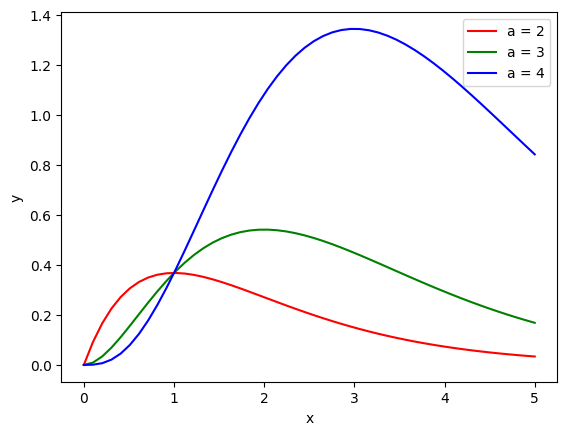

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def func(x, a):
  return (x ** (a - 1)) * np.exp(-x)

x = np.linspace(0, 5, 50)
y_2 = [func(x_i, 2) for x_i in x]
y_3 = [func(x_i, 3) for x_i in x]
y_4 = [func(x_i, 4) for x_i in x]

plt.plot(x, y_2, color = "r", label = "a = 2")
plt.plot(x, y_3, color = "g", label = "a = 3")
plt.plot(x, y_4, color = "b", label = "a = 4")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

**(b)** Show analytically that the maximum falls at $x=a-1$.

$$\frac{\text{d} }{\text{d} x} x^{a-1}e^{-x}=(a-1)x^{a-2}e^{-x}-x^{a-1}e^{-x}=e^{-x}x^{a-2}(a-1-x)$$
Then, $\frac{\text{d} }{\text{d} x} x^{a-1}e^{-x}\geqslant 0$ on $[0, a-1)$, $\frac{\text{d} }{\text{d} x} x^{a-1}e^{-x} < 0 $ on $(a-1, \infty)$. Thus the function $x^{a-1}e^{-x}$ increases on $[0, a-1)$ and decreases on $(a-1, \infty)$, and the maximum falls at $x=a-1$.

**(c)** Most of the area under the integrand falls near the maximum, so to get an accurate value of the gamma function we need to do a good job of this part of the integral. We can change the integral from $0$ to $\infty$ to one over a finite range from $0$ to $1$ using the change of variables in Eq. (5.67), but this tends to squash the peak towards the edge of the $[0, 1]$ range and does a poor job of evaluating the integral accurately. We can do a better job by making a different change of variables that puts the peak in the middle of the integration range, around $\frac{1}{2}$. We will use the change of variables given in Eq. (5.69), which we repeat here for convenience:
$$z=\frac{x}{c+x}$$
For what value of $x$ does this change of variables give $z = \frac{1}{2}$? Hence what is the appropriate choice of the parameter $c$ that puts the peak of the integrand for the gamma function at $z = \frac{1}{2}$?

When $x=c$, $z=\frac{c}{c+c}=\frac{1}{2}$.

According to (b), the appropriate choice of $c$ is $c=a-1$.

**(d)** Before we can calculate the gamma function, there is another detail we need to attend to. The integrand $x^{a-1}e^{-x}$ can be difficult to evaluate because the factor $x^{a-1}$ can become very large and the factor $e^{-x}$ very small, causing numerical overflow or underflow, or both, for some values of $x$. Write $x^{a-1}=e^{(a-1)\text{ln}x}$ to derive an alternative expression for the integrand that does not suffer from these problems (or at least not so much). Explain why your new expression is better than the old one.

$$x^{a-1}e^{-x}=e^{(a-1)\text{ln}x}e^{-x}=e^{-x+(a-1)\text{ln}x}$$
Firstly, This allows the entire exponential term to be calculated at once, rather than calculating the two terms separately and then multiplying them together, which reduces the amount of computation and minimizes cumulative rounding errors. This also computationally avoids multiplying a very large number with a very small number, a situation that could lead to numerical stability problems.

Secondly, for very large $x$, directly calculating $x^{a-1}$ may cause numerical overflow since the value exceeds the range of floating point number. And $(a-1)\text{ln}(x)$ may still be in the representable range because logarithmic functions grow slower than power functions.

**(e)** Now, using the change of variables above and the value of $c$ you have chosen, write a user-defined function gamma($a$) to calculate the gamma function for arbitrary argument $a$. Use whatever integration method you feel is appropriate. Test
your function by using it to calculate and print the value of $\Gamma(\frac{3}{2})$, which is known to be equal to $\frac{1}{2} \sqrt{\pi } \simeq 0.886$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


def gaussxw(N):
    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3, 4 * N - 1, N) / (4 * N + 2)
    x = np.cos(np.pi * a + 1/(8 * N * N * np.tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta > epsilon:
        p0 = np.ones(N, float)
        p1 = np.copy(x)
        for k in range(1, N):
            p0, p1 = p1, ((2 * k + 1) * x * p1 - k * p0) / (k + 1)
        dp = (N + 1) * (p0 - x * p1) / (1 - x * x)
        dx = p1 / dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2 * (N + 1) * (N + 1) / (N * N * (1 - x * x) * dp * dp)

    return x, w

def gaussxwab(N, a, b):
    x, w = gaussxw(N)
    return 0.5 * (b - a) * x + 0.5 * (b + a), 0.5 * (b - a) * w

# Here the integrand of Gamma function has already been dealed with change of variables.
def integrand(a, z):
  return np.exp(((a - 1) * z) / (z - 1) + (a - 1) * np.log(((1 - a) * z) / (z - 1))) * ((a - 1) / ((1 - z) ** 2))

# Use Gaussian quadrature to calculate the integral
def integral(func, a, N = 100):
  x, w = gaussxwab(N, 0, 1)
  result = 0

  for i in range(0, N):
    result += w[i] * func(a, x[i])

  return result

print("The calculated value of Gamma(3/2) is:", integral(integrand, 3 / 2))

The calculated value of Gamma(3/2) is: 0.8862269613087213


**(f)** For integer values of n it can be shown that $\Gamma(n)$ is equal to the factorial of $n-1$. Use your Python function to calculate $\Gamma(3)$, $\Gamma(6)$, and $\Gamma(10)$. You should get answers closely equal to $2! = 2$, $5! = 120$, and $9! = 362880$.

In [ ]:
def integral_int(func, a, N = 100):
  x, w = gaussxwab(N, 0, 1)
  result = 0

  for i in range(0, N):
    result += w[i] * func(a, x[i])

  return round(result)

print("The calculated value of Gamma(3) is:", integral_int(integrand, 3))
print("The calculated value of Gamma(6) is:", integral_int(integrand, 6))
print("The calculated value of Gamma(10) is:", integral_int(integrand, 10))

The calculated value of Gamma(3) is: 2
The calculated value of Gamma(6) is: 120
The calculated value of Gamma(10) is: 362880


## 6. Exercise 5.18
Rearranging Eq. (5.19) into a slightly more conventional form, we have:
$$\int^{b}_{a} f(x)\text{d} x=h\left[ \frac{1}{2} f(a)+\frac{1}{2} f(b)+\sum^{N-1}_{k=1} f(a+kh)\right]  +\frac{1}{12} h^{2}\left[ f^{\prime }(a)-f^{\prime }(b)\right]  +O(h^{4})$$
This result gives a value for the integral on the left which has an error of order $h^{4}$ -- a factor of $h^{2}$ better than the error on the trapezoidal rule and as good as Simpson's rule. We can use this formula as a new rule for evaluating integrals, distinct from any of the others we have seen in this chapter. We might call it the "Euler-Maclaurin rule."

**(a)** Write a program to calculate the value of the integral $\int^{2}_{0} \left( x^{4}-2x+1\right)  \text{d} x$ using this formula. (This is the same integral that we studied in Example 5.1, whose true value is 4.4.) The order-$h$ term in the formula is just the ordinary trapezoidal rule;
the $h^{2}$ term involves the derivatives $f'(a)$ and $f'(b)$, which you should evaluate using central differences, centered on $a$ and $b$ respectively. Note that the size of the interval you use for calculating the central differences does not have to equal the value of $h$ used in the trapezoidal rule part of the calculation. An interval of about $10^{-5}$  gives good values for the central differences. Use your program to evaluate the integral with N = 10 slices and compare the accuracy of the result with that obtained from the trapezoidal rule alone with the same number of slices.

In [ ]:
import numpy as np


def integrand(x):
  return x ** 4 - 2 * x + 1

def central_diff(func, x, dx):
  return (func(x + dx) - func(x - dx)) / (2 * dx)

def integral(func, a, b):
  result = 0
  N = 10
  diff_a = central_diff(integrand, a, 1e-5)
  diff_b = central_diff(integrand, b, 1e-5)

  sum = 0
  h = abs(b - a) / N

  for i in range(1, N):
    sum += func(a + i * h)

  result = h * (((1 / 2) * (func(a) + func(b))) + sum) + (1 / 12) * (h ** 2) * (diff_a - diff_b)

  return result

def trapezoidal(func, a, b):
  result = 0
  N = 10
  sum = 0
  h = abs(b - a) / N

  for i in range(1, N):
    sum += func(a + i * h)

  result = h * (((1 / 2) * (func(a) + func(b))) + sum)

  return result


print("The intrgral calculated by Euler-Maclaurin rule is:", integral(integrand, 0, 2), "the absolute error is:", abs(integral(integrand, 0, 2) - 4.4))
print("The intrgral calculated by Trapezoidal rule is:", trapezoidal(integrand, 0, 2), "the absolute error is:", abs(trapezoidal(integrand, 0, 2) - 4.4))

The intrgral calculated by Euler-Maclaurin rule is: 4.399893333330025 the absolute error is: 0.0001066666699749419
The intrgral calculated by Trapezoidal rule is: 4.50656 the absolute error is: 0.10655999999999999


**(b)** Good though it is, this integration method is not much used in practice. Suggest a reason why not.

Since including the central differences around the endpoints, the Euler-Maclaurin rule may not apply to non-derivable functions. Also, higher order terms with $h^{2}$ may lead to numerical accuracy problems, introducing additional errors.

## 7. Exercise 5.19
Light with wavelength $\lambda$ is incident on a diffraction grating
of total width $w$, gets diffracted, is focused with a lens of focal length $f$, and falls on a screen. Theory tells us that the intensity of the diffraction pattern on the screen, a distance $x$ from the central axis of the system, is given by
$$I(x)=\left| \int^{w/2}_{-w/2} \sqrt{q(u)} e^{i2\pi xu/\lambda f}\text{d} u\right|^{2}  $$
where $q(u)$ is the intensity transmission function of the diffraction grating at a distance $u$ from the central axis, i.e., the fraction of the incident light that the grating lets through.


**(a)**  Consider a grating with transmission function $q(u) = \text{sin}^{2} \alpha u$. What is the separation of the "slits" in this grating, expressed in terms of $\alpha$?

The separation of the "slits" in this grating is
$d=\frac{\pi }{\alpha } $.


**(b)** Write a Python function $q(u)$ that returns the transmission function $q(u) = \text{sin}^{2} \alpha u$
as above at position $u$ for a grating whose slits have separation $20 \mu m$.

In [ ]:
import numpy as np


def q(u):
  d = 20e-6
  alpha = np.pi / d
  return (np.sin(alpha * u)) ** 2

**(c)** Use your function in a program to calculate and graph the intensity of the diffraction pattern produced by such a grating having ten slits in total, if the incident light has wavelength $\lambda = 500 nm$. Assume the lens has a focal length of $1$ meter and the screen is $10 cm$ wide. You can use whatever method you think appropriate for doing the integral. Once you've made your choice you'll also need to decide the number of sample points you'll use. What criteria play into this decision? Notice that the integrand in the equation for $I(x)$ is complex, so you will have to use complex variables in your program. As mentioned in Section 2.2.5, there is a version of the math package for use with complex variables called cmath. In particular you may find the exp function from cmath useful because it can calculate the exponentials of complex arguments.

In [24]:
import numpy as np
import cmath
import matplotlib.pyplot as plt


d = 20e-6
alpha = np.pi / d
slits = 10
wlength = 500e-9
flength = 1
screenwidth = 0.1
w = d * slits
start = -w / 2 # Start point
end = w / 2 # End point
slices = 1000 # number of slices for Simpson's rule

def q(u):
    return np.sin(alpha * u) ** 2

def f(u, x):
    return cmath.sqrt(q(u)) * cmath.exp(1j * 2 * np.pi * x * u / (wlength * flength))

def Simpson(start, end, slices, x):
    a = start
    b = end
    N = slices
    h = (b - a) / N
    s = f(a, x) + f(b, x)

    # Odd terms
    for i in range(1, N, 2):
        s += 4 * f(a + i * h, x)

    # Even terms
    for i in range(2, N, 2):
        s += 2 * f(a + i * h, x)

    return((1 / 3) * h * s)

x_range = np.linspace(-0.05, 0.05, 200)

intensities = []

def I(x):
    integral = Simpson(start, end, slices, x)
    intensity = (abs(integral)) ** 2
    return intensity

for i in x_range:
    intensities.append(I(i))

**(d)** Create a visualization of how the diffraction pattern would look on the screen using a density plot (see Section 3.3).

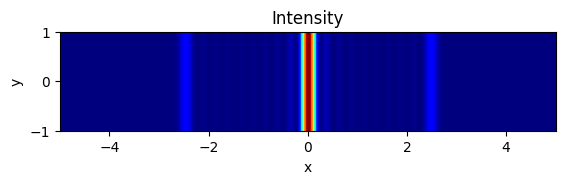

In [25]:
screen = np.zeros([len(intensities), len(intensities)])

for i in range(0, len(intensities), 1):
    for k in range(0, len(intensities), 1):
        screen[i, k] = intensities[k]

plt.imshow(screen, extent=[-5, 5, -1, 1])
plt.title("Intensity")
plt.xlabel("x")
plt.ylabel("y")
plt.jet()

**(e)** Modify your program further to make pictures of the diffraction patterns produced by gratings with the following profiles:

(i) A transmission profile that obeys $q(u)=\text{sin}^{2} \alpha u\  \text{sin}^{2} \beta u$, with a as before and
the same total grating width $w$, and $\beta = \frac{1}{2} a$.

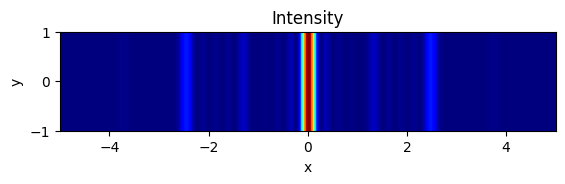

In [22]:
d = 20e-6
alpha = np.pi / d
beta = (1 / 2) * alpha
slits = 10
wlength = 500e-9
flength = 1
screenwidth = 0.1
w = d * slits
start = -w / 2
end = w / 2
slices = 1000

def q(u):
    return (np.sin(alpha * u) ** 2) * (np.sin(beta * u) ** 2)

def f(u, x):
    return cmath.sqrt(q(u)) * cmath.exp(1j * 2 * np.pi * x * u / (wlength * flength))

def Simpson(start, end, slices, x):
    a = start
    b = end
    N = slices
    h = (b - a) / N
    s = f(a, x) + f(b, x)

    # Odd terms
    for i in range(1, N, 2):
        s += 4 * f(a + i * h, x)

    # Even terms
    for i in range(2, N, 2):
        s += 2 * f(a + i * h, x)

    return((1 / 3) * h * s)

x_range = np.linspace(-0.05, 0.05, 200)

intensities = []

def I(x):
    integral = Simpson(start, end, slices, x)
    intensity = (abs(integral)) ** 2
    return intensity

for i in x_range:
    intensities.append(I(i))

screen = np.zeros([len(intensities), len(intensities)])

for i in range(0, len(intensities), 1):
    for k in range(0, len(intensities), 1):
        screen[i, k] = intensities[k]

plt.imshow(screen, extent=[-5, 5, -1, 1])
plt.title("Intensity")
plt.xlabel("x")
plt.ylabel("y")
plt.jet()

(ii) Two "square" slits, meaning slits with $100\% $ transmission through the slit and $0\% $ transmission everywhere else. Calculate the diffraction pattern for non-identical slits, one $10 \mu m$ wide and the other $20 \mu m$ wide, with a $60 \mu m$ gap between the two.

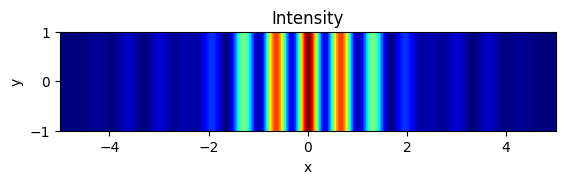

In [26]:
slits = 10
wlength = 500e-9
flength = 1
screenwidth = 0.1
w = 100e-6
start = -w / 2
end = w / 2
slices = 1000

# Left slit 10e-6 m wide, right slit 20e-6 m wide, gap of 5e-6 m on each side
def f(u, x):
    # Gap on left side
    if u >= -w / 2 and u < (-w / 2) + 5e-6:
        return 0
    # Left slit
    if u >= (-w / 2) + 5e-6 and u < (-w / 2) + 15e-6:
        return cmath.exp(1j * 2 * np.pi * x * u / (wlength * flength))
    # Gap between two slits
    if u >= (-w / 2) + 15e-6 and u < w / 2 - 25e-6:
        return 0
    # Right slit
    if u >= w / 2 - 25e-6 and u < w / 2 - 5e-6:
        return cmath.exp(1j * 2 * np.pi * x * u / (wlength * flength))
    # Gap on right side
    if u >= w / 2 - 5e-6 and u <= w / 2:
        return 0

def Simpson(start, end, slices, x):
    a = start
    b = end
    N = slices
    h = (b - a) / N
    s = f(a, x) + f(b, x)

    # Odd terms
    for i in range(1, N, 2):
        s += 4 * f(a + i * h, x)

    # Even terms
    for i in range(2, N, 2):
        s += 2 * f(a + i * h, x)

    return((1 / 3) * h * s)

x_range = np.linspace(-0.05, 0.05, 200)

intensities = []

def I(x):
    integral = Simpson(start, end, slices, x)
    intensity = (abs(integral)) ** 2
    return intensity

for i in x_range:
    intensities.append(I(i))

screen = np.zeros([len(intensities), len(intensities)])

for i in range(0, len(intensities), 1):
    for k in range(0, len(intensities), 1):
        screen[i, k] = intensities[k]

plt.imshow(screen, extent=[-5, 5, -1, 1])
plt.title("Intensity")
plt.xlabel("x")
plt.ylabel("y")
plt.jet()

## 8. Exercise 5.21
Suppose we have a distribution of charges and we want to calculate the resulting electric field. One way to do this is to first calculate the electric potential $\phi $ and then take its gradient. For a point charge $q$ at the origin, the electric potential at a distance $r$ from the origin is $\phi =\frac{q}{4\pi \varepsilon_{0} r} $ and the electric field is $E=-\nabla \phi $.

**(a)** You have two charges, of $\pm 1\text{C} $, $10cm$ apart. Calculate the resulting electric potential on a $1m\times 1m$ square plane surrounding the charges and passing through them. Calculate the potential at $1 cm$ spaced points in a grid and make a visualization on the screen of the potential using a density plot.

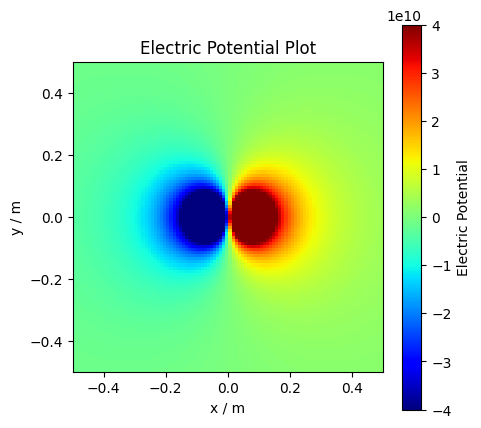

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


epsilon_0 = 8.854e-12

def potential(x, y):
  r_1 = np.sqrt((x - 0.05) ** 2 + y ** 2)
  r_2 = np.sqrt((x + 0.05) ** 2 + y ** 2)
  potential_1 = 1 / (4 * np.pi * epsilon_0 * r_1)
  potential_2 = -1 / (4 * np.pi * epsilon_0 * r_2)

  return potential_1 + potential_2

x = np.linspace(-0.5, 0.5, 100)
y = np.linspace(-0.5, 0.5, 100)
pts = [[potential(x_i, y_i) for x_i in x] for y_i in y]

# For values too large, use a maxvalue
max_value = 4e10
for i in range(0, 100):
  for j in range(0, 100):
    if abs(pts[i][j]) > max_value:
      if pts[i][j] < 0:
        pts[i][j] = -max_value
      else:
        pts[i][j] = max_value

plt.figure(figsize = (5, 5))
plt.imshow(pts, extent = (-0.5, 0.5, -0.5, 0.5))
plt.colorbar(label = 'Electric Potential')
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.title('Electric Potential Plot')
plt.show()

**(b)** Now calculate the partial derivatives of the potential with respect to x and y and hence find the electric field in the $xy$ plane. Make a visualization of the field also. This is a little trickier than visualizing the potential, because the electric field has both magnitude and direction. One way to do it might be to make two density plots, one for the magnitude, and one for the direction, the latter using the "hsv" color scheme in pylab, which is a rainbow scheme that passes through all the colors but starts and ends with the same shade of red, which makes it suitable for representing things like directions or angles that go around the full circle and end up where they started. A more sophisticated visualization might use the arrow object from the visual package, drawing a grid of arrows with direction and length chosen to represent the field.

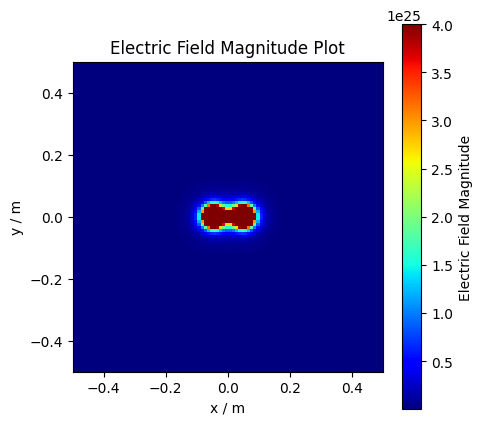

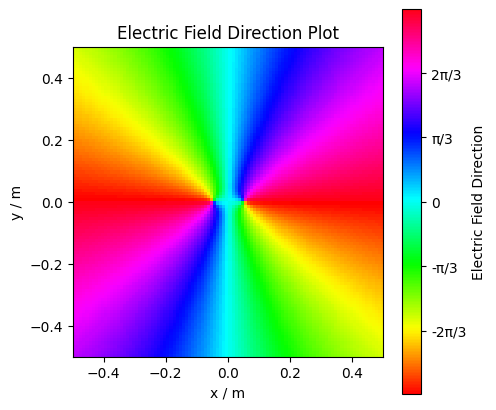

In [ ]:
def field_magnitude(x, y):
  pot = potential(x, y)
  dx = 1e-10
  dy = 1e-10
  x_diff = (potential(x + dx, y) - potential(x - dx, y)) / (2 * dx)
  y_diff = (potential(x, y + dy) - potential(x, y - dy)) / (2 * dy)

  return (x_diff ** 2 + y_diff ** 2)

def field_direction(x, y):
  pot = potential(x, y)
  dx = 1e-10
  dy = 1e-10
  x_diff = (potential(x + dx, y) - potential(x - dx, y)) / (2 * dx)
  y_diff = (potential(x, y + dy) - potential(x, y - dy)) / (2 * dy)

  return np.arctan2(y_diff, x_diff)

x = np.linspace(-0.5, 0.5, 100)
y = np.linspace(-0.5, 0.5, 100)
mag = [[field_magnitude(x_i, y_i) for x_i in x] for y_i in y]
dir = [[field_direction(x_i, y_i) for x_i in x] for y_i in y]

# For values too large, use a maxvalue
max_value = 4e25
for i in range(0, 100):
  for j in range(0, 100):
    if abs(mag[i][j]) > max_value:
      if mag[i][j] < 0:
        mag[i][j] = -max_value
      else:
        mag[i][j] = max_value

plt.figure(figsize = (5, 5))
plt.imshow(mag, extent = (-0.5, 0.5, -0.5, 0.5))
plt.colorbar(label = 'Electric Field Magnitude')
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.title('Electric Field Magnitude Plot')
plt.show()

plt.figure(figsize = (5, 5))
plt.imshow(dir, extent = (-0.5, 0.5, -0.5, 0.5), cmap = 'hsv')
cbar = plt.colorbar(label='Electric Field Direction', ticks=[-np.pi, -2 * np.pi / 3, -np.pi / 3, 0, np.pi / 3, 2 * np.pi / 3, np.pi])
cbar.set_ticklabels(['-π', '-2π/3', '-π/3', '0', 'π/3', '2π/3', 'π'])
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.title('Electric Field Direction Plot')
plt.show()

**(c)** Now suppose you have a continuous distribution of charge over an $L\times L$ square. The charge density in $\text{C}\ m^{-2}$ is
$$\sigma (x,y)=q_{0}\sin \frac{2\pi x}{L} \sin \frac{2\pi y}{L} $$
Calculate and visualize the resulting electric field at $1 cm$-spaced points in $1$ square meter of the $xy$ plane for the case where $L = 10 cm$, the charge distribution is centered in the middle of the visualized area, and $q_{0} = 100\text{C}\ m^{-2}$ . You will have to perform a double integral over $x$ and $y$, then differentiate the potential with respect to position to get the electric field. Choose whatever integration method seems appropriate for the integrals.

This is the code for manually deriving the gradient with central differentiate method:

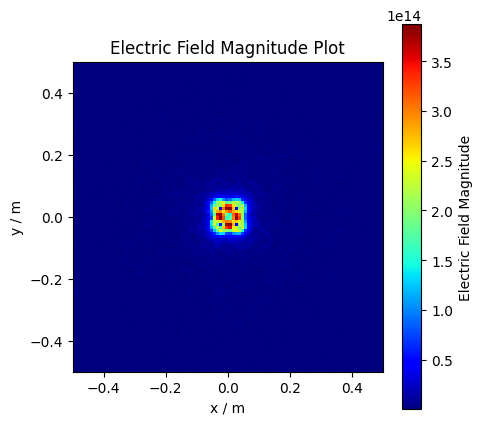

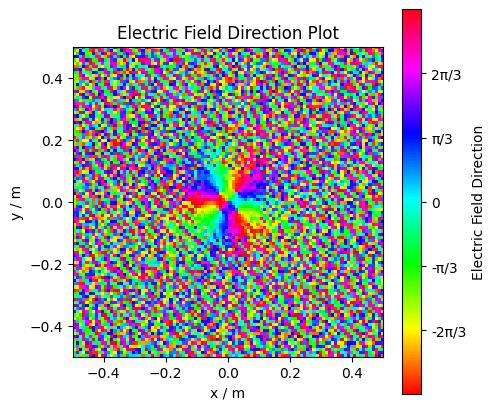

In [66]:
import numpy as np
import matplotlib.pyplot as plt

epsilon_0 = 8.854e-12
q_0 = 100
L = 0.1

def Monte_Carlo(f, N):
    random_x = np.random.uniform(-L / 2, L / 2, N)
    random_y = np.random.uniform(-L / 2, L / 2, N)
    return np.mean(f(random_x, random_y))

def sigma(x, y):
    return q_0 * np.sin(2 * np.pi * x / L) * np.sin(2 * np.pi * y / L)

def V(a, b, N = 10000):
    def integrand(x, y):
        r = np.sqrt((a - x) ** 2 + (b - y) ** 2)
        return sigma(x, y) / r
    return Monte_Carlo(lambda x, y: integrand(x, y), N) / (4 * np.pi * epsilon_0)

x = np.linspace(-0.5, 0.5, 100)
y = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(x, y)

V_vectorized = np.vectorize(V)
V_grid = V_vectorized(X, Y)

dx = 1e-2
dy = 1e-2

def derivative_x(V, X, Y, dx):
    Ex = np.zeros_like(V)
    Ex[1:-1, :] = (V[2:, :] - V[:-2, :]) / (2 * dx)
    Ex[0, :] = (V[1, :] - V[0, :]) / dx
    Ex[-1, :] = (V[-1, :] - V[-2, :]) / dx
    return Ex

def derivative_y(V, X, Y, dy):
    Ey = np.zeros_like(V)
    Ey[:, 1:-1] = (V[:, 2:] - V[:, :-2]) / (2 * dy)
    Ey[:, 0] = (V[:, 1] - V[:, 0]) / dy
    Ey[:, -1] = (V[:, -1] - V[:, -2]) / dy
    return Ey

Ex = derivative_x(V_grid, X, Y, dx)
Ey = derivative_y(V_grid, X, Y, dy)

mag = np.sqrt(Ex**2 + Ey**2)
dir = np.arctan2(Ey, Ex)

plt.figure(figsize=(5, 5))
plt.imshow(mag, extent=(-0.5, 0.5, -0.5, 0.5))
plt.colorbar(label='Electric Field Magnitude')
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.title('Electric Field Magnitude Plot')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(dir, extent=(-0.5, 0.5, -0.5, 0.5), cmap='hsv')
cbar = plt.colorbar(label='Electric Field Direction', ticks=[-np.pi, -2 * np.pi / 3, -np.pi / 3, 0, np.pi / 3, 2 * np.pi / 3, np.pi])
cbar.set_ticklabels(['-π', '-2π/3', '-π/3', '0', 'π/3', '2π/3', 'π'])
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.title('Electric Field Direction Plot')
plt.show()


This method uses **gradient** in **numpy** to derive the electric field, which gives more accurate results than manually deriving the gradient:

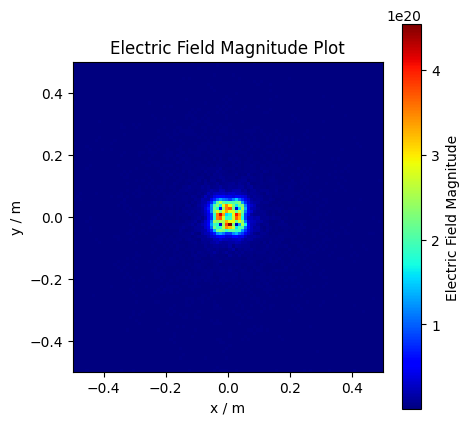

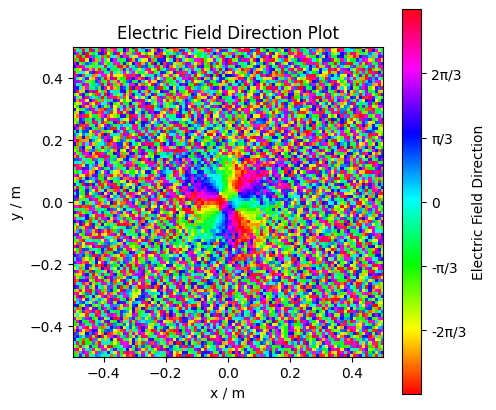

In [61]:
import numpy as np
import matplotlib.pyplot as plt

epsilon_0 = 8.854e-12
q_0 = 100
L = 0.1

def Monte_Carlo(f, N):
    random_x = np.random.uniform(-L / 2, L / 2, N)
    random_y = np.random.uniform(-L / 2, L / 2, N)
    return np.mean(f(random_x, random_y))

def sigma(x, y):
    return q_0 * np.sin(2 * np.pi * x / L) * np.sin(2 * np.pi * y / L)

def V(a, b, N = 10000):
    def integrand(x, y):
        r = np.sqrt((a - x) ** 2 + (b - y) ** 2)
        return sigma(x, y) / r
    return Monte_Carlo(lambda x, y: integrand(x, y), N) / (4 * np.pi * epsilon_0)

x = np.linspace(-0.5, 0.5, 100)
y = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(x, y)

V_vectorized = np.vectorize(V)
V_grid = V_vectorized(X, Y)

dx = 1e-8
dy = 1e-8

Ex, Ey = np.gradient(V_grid, dx, dy)

mag = np.sqrt(Ex ** 2 + Ey ** 2)
dir = np.arctan2(Ey, Ex)

plt.figure(figsize=(5, 5))
plt.imshow(mag, extent=(-0.5, 0.5, -0.5, 0.5))
plt.colorbar(label='Electric Field Magnitude')
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.title('Electric Field Magnitude Plot')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(dir, extent=(-0.5, 0.5, -0.5, 0.5), cmap='hsv')
cbar = plt.colorbar(label='Electric Field Direction', ticks=[-np.pi, -2 * np.pi / 3, -np.pi / 3, 0, np.pi / 3, 2 * np.pi / 3, np.pi])
cbar.set_ticklabels(['-π', '-2π/3', '-π/3', '0', 'π/3', '2π/3', 'π'])
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.title('Electric Field Direction Plot')
plt.show()
